# **Feed Forward Neural Network**
**Starting parameters**:

- Number of epochs: 100
- Learning rate: 0.00001
- Layers: [128, 64, 64]
- Dropout: 0.4


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
# Standard libraries
import numpy as np
import pandas as pd
import time
import os

# For preprocessing
import tensorflow as tf

# For modeling
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, roc_auc_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Operational
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import random

In [20]:
pkl_path = '/content/drive/My Drive/Final-Year-Project/Dataset/Final-Version-of-Bird-Classification-Project/feature-extraction/NotAnnotated/Regular/AveragePooled/split_features_6s_all_1D.pkl'

# Load the pickle file
with open(pkl_path, 'rb') as file:
    data = pickle.load(file)

In [21]:
path = '/content/drive/My Drive/Final-Year-Project/Final-Version-of-Bird-Classification-Project/a. Imbalanced-Data/3. Training/Figures/FFNN/'

In [22]:
train_data = data['train'].copy()
val_data = data['val'].copy()

train_labels = train_data['label'].copy()
temp = train_data.copy()
del temp['label']
tr_features = temp

val_labels = val_data['label'].copy()
temp = val_data.copy()
del temp['label']
v_features = temp

## **Shuffling Data**

In [23]:
def shuffle_data(input_label, input_features):
  input_len = len(input_label)
  np.random.seed(1826)
  input_indices = np.random.permutation(input_len)
  input_features = {key: np.array([input_features[key][i] for i in input_indices]) for key in input_features} # dictionary comprehension
  input_label = np.array([input_label[i] for i in input_indices])

  return input_label, input_features

In [24]:
train_y, train_features = shuffle_data(train_labels, tr_features)

In [25]:
val_y, val_features = shuffle_data(val_labels, v_features)

## **Feed Forward Model**

In [26]:
def build_model(input_features,
                hidden_layers=[128, 64, 64],
                learning_rate=0.00001,
                output_units=20,
                dropout_rate=0.4):

  tf.keras.backend.clear_session()

  # set input layer
  input = tf.keras.Input(shape=(input_features,), name='Input')

  # set hidden layers
  hidden_output = input

  for i, hidden_dim in enumerate(hidden_layers):
    hidden_output = tf.keras.layers.Dense(units=hidden_dim,
                                          activation='relu',
                                          name=f'hidden{i}')(hidden_output)
    # hidden_output = tf.keras.layers.Dropout(rate=dropout_rate, name=f'dropout{i}')(hidden_output)

  # set output layer
  output = tf.keras.layers.Dense(units=output_units,
                                 activation='softmax',
                                 name='Output')(hidden_output)
  # create model
  model = tf.keras.models.Model(inputs=input, outputs=[output])

  # compile model
  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                metrics=['accuracy'])

  return model

In [27]:
def visualize(model_history, name):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Visualize the loss
    axes[0].plot(model_history.history['loss'], color='red', label='Training Loss')
    axes[0].plot(model_history.history['val_loss'], color='blue', label='Validation Loss')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Loss Progression', fontsize=14)
    axes[0].grid(True)
    axes[0].legend()

    # Visualize the accuracy
    axes[1].plot(model_history.history['accuracy'], color='green', label='Training Accuracy')
    axes[1].plot(model_history.history['val_accuracy'], color='orange', label='Validation Accuracy')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title('Accuracy Progression', fontsize=14)
    axes[1].grid(True)
    axes[1].legend()

    plt.savefig(f'{path+name}_model_training_history_1D.pdf')

    # Fine-tune layout and display the plots
    plt.tight_layout()
    plt.show()

In [28]:
def evaluate_model(val_y, val_yhat, val_yhat_result, num_classes=20):

    print('Validation classification Report \n')
    print(classification_report(val_y, val_yhat_result))

    # Calculate AUC for multiclass classification using 'ovr' and 'weighted' average
    auc_score = roc_auc_score(val_y, val_yhat, multi_class='ovr', average='weighted')
    print(f'AUC Score: {auc_score}')

    # Calculate F1-score with 'weighted' average for imbalanced dataset
    f1 = f1_score(val_y, val_yhat_result, average='weighted')
    print(f'F1 Score (Weighted): {f1}')

    val_score = {'f1': f1, 'auc': auc_score}

    return val_score

In [29]:
train_results = {}
val_results = {}

val_scores = {}

### With All Features

In [30]:
training_features = np.concatenate((train_features['mfcc'], train_features['chroma'], train_features['cqt'], train_features['melspectrogram']), axis=1)
training_features.shape

(6543, 244)

In [31]:
validation_features = np.concatenate((val_features['mfcc'], val_features['chroma'], val_features['cqt'], val_features['melspectrogram']), axis=1)
validation_features.shape

(2028, 244)

In [32]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1])

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=0,
)

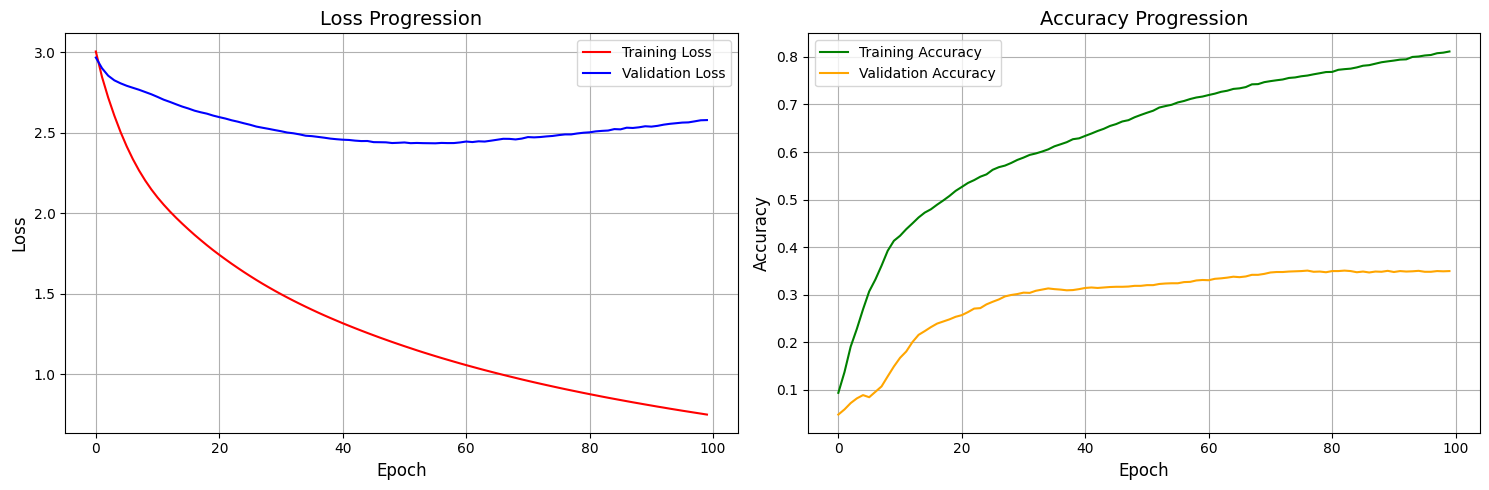

In [33]:
visualize(history, '6s_all_features')

In [34]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['all_features'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['all_features'] = model.evaluate(validation_features, val_y)[-1]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step - accuracy: 0.8151 - loss: 0.7301
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - accuracy: 0.3531 - loss: 2.5754


In [35]:
val_scores['all_features'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.35      0.37      0.36       126
           1       0.50      0.51      0.50       205
           2       0.33      0.42      0.37        96
           3       0.23      0.75      0.35       152
           4       0.00      0.00      0.00        33
           5       0.19      0.12      0.15        48
           6       0.00      0.00      0.00        38
           7       0.48      0.65      0.55       107
           8       0.07      0.04      0.05        24
           9       0.30      0.44      0.35        32
          10       0.48      0.64      0.55        69
          11       0.12      0.01      0.01       272
          12       0.40      0.30      0.34       203
          13       0.11      0.08      0.09        76
          14       0.03      0.10      0.05        20
          15       0.37      0.39      0.38       119
          16       0.80      0.91      0.85   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Mel Spectrogram and Chroma

In [36]:
training_features = np.concatenate((train_features['melspectrogram'], train_features['chroma']), axis=1)
training_features.shape

(6543, 140)

In [37]:
validation_features = np.concatenate((val_features['melspectrogram'], val_features['chroma']), axis=1)
validation_features.shape

(2028, 140)

In [38]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1])

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=0,
)

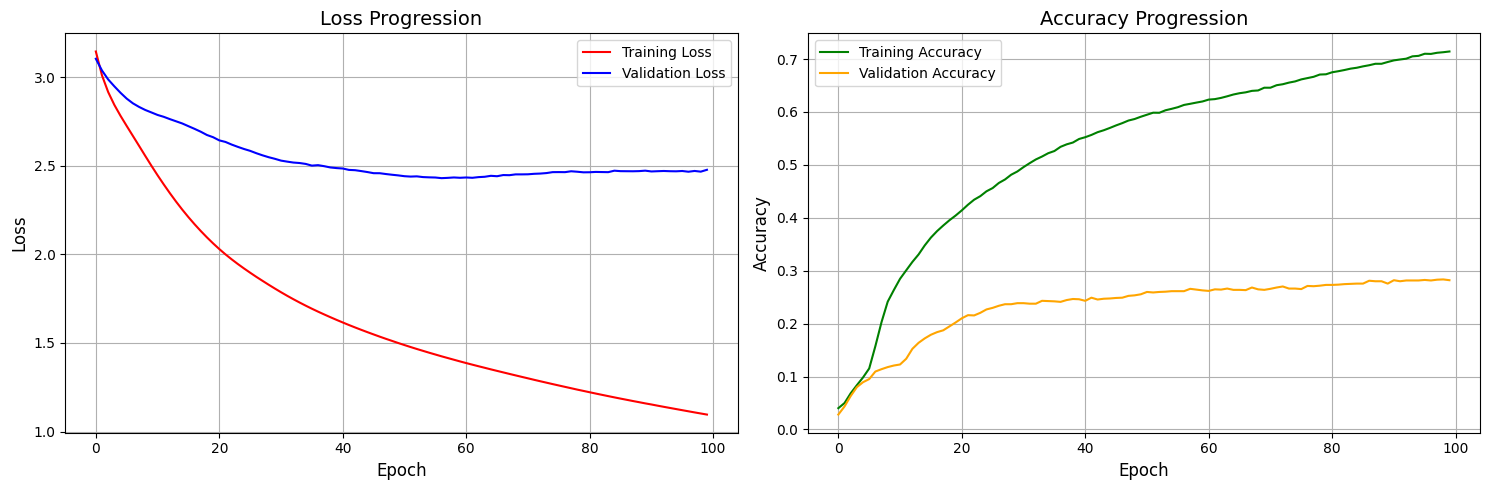

In [39]:
visualize(history, '6s_melspectrogram_chroma')

In [40]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram_chroma'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram_chroma'] = model.evaluate(validation_features, val_y)[-1]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - accuracy: 0.7215 - loss: 1.0723
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - accuracy: 0.2802 - loss: 2.4767


In [41]:
val_scores['melspectrogram_chroma'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.39      0.55      0.45       126
           1       0.50      0.43      0.47       205
           2       0.35      0.43      0.38        96
           3       0.29      0.67      0.40       152
           4       0.00      0.00      0.00        33
           5       0.12      0.12      0.12        48
           6       0.00      0.00      0.00        38
           7       0.41      0.48      0.44       107
           8       0.16      0.38      0.22        24
           9       0.19      0.44      0.27        32
          10       0.25      0.20      0.22        69
          11       0.10      0.00      0.01       272
          12       0.16      0.17      0.17       203
          13       0.18      0.08      0.11        76
          14       0.00      0.00      0.00        20
          15       0.27      0.24      0.25       119
          16       0.26      0.18      0.21   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### With Mel Spectrogram, MFCCs and Chroma

In [42]:
training_features = np.concatenate((train_features['melspectrogram'], train_features['chroma'], train_features['mfcc']), axis=1)
training_features.shape

(6543, 160)

In [43]:
validation_features = np.concatenate((val_features['melspectrogram'], val_features['chroma'], val_features['mfcc']), axis=1)
validation_features.shape

(2028, 160)

In [44]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1])

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=0,
)

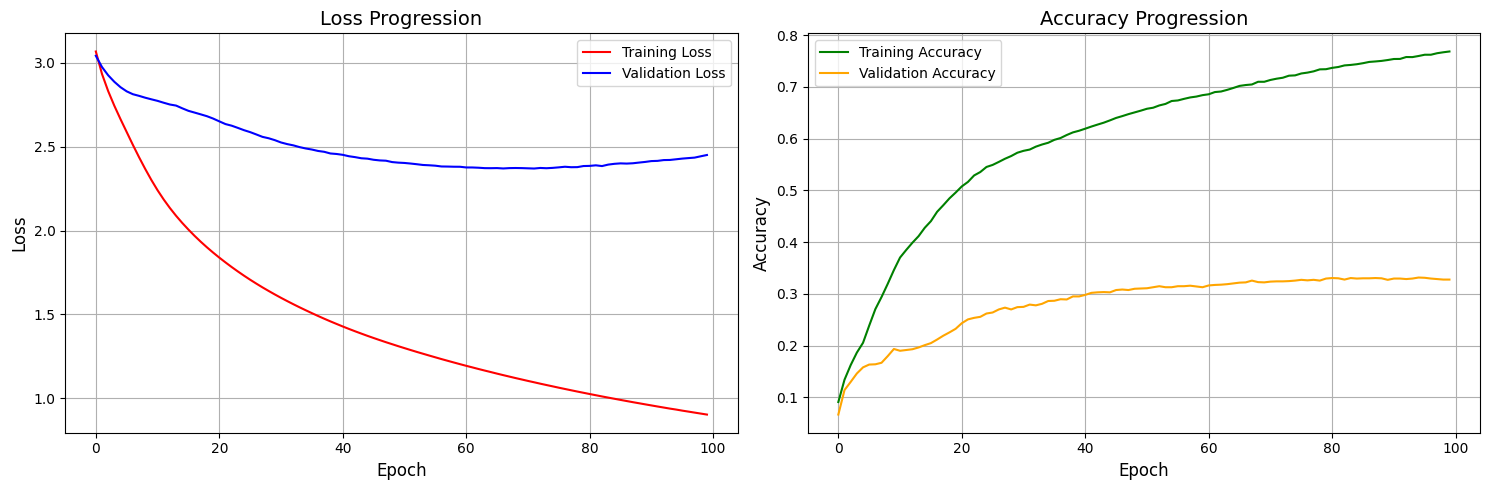

In [45]:
visualize(history, '6s_melspectrogram_chroma_mfcc')

In [46]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram_chroma_mfcc'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram_chroma_mfcc'] = model.evaluate(validation_features, val_y)[-1]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step - accuracy: 0.7717 - loss: 0.8773
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - accuracy: 0.3276 - loss: 2.4465


In [47]:
val_scores['melspectrogram_chroma_mfcc'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.27      0.43      0.33       126
           1       0.47      0.48      0.48       205
           2       0.42      0.44      0.43        96
           3       0.23      0.63      0.34       152
           4       0.00      0.00      0.00        33
           5       0.06      0.06      0.06        48
           6       0.00      0.00      0.00        38
           7       0.43      0.59      0.50       107
           8       0.00      0.00      0.00        24
           9       0.44      0.44      0.44        32
          10       0.35      0.36      0.35        69
          11       0.50      0.00      0.01       272
          12       0.34      0.26      0.29       203
          13       0.35      0.14      0.21        76
          14       0.03      0.05      0.04        20
          15       0.28      0.27      0.27       119
          16       0.48      0.81      0.61   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### With Mel Spectrogram and MFCCs

In [48]:
training_features = np.concatenate((train_features['melspectrogram'], train_features['mfcc']), axis=1)
training_features.shape

(6543, 148)

In [49]:
validation_features = np.concatenate((val_features['melspectrogram'], val_features['mfcc']), axis=1)
validation_features.shape

(2028, 148)

In [50]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1])

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=0,
)

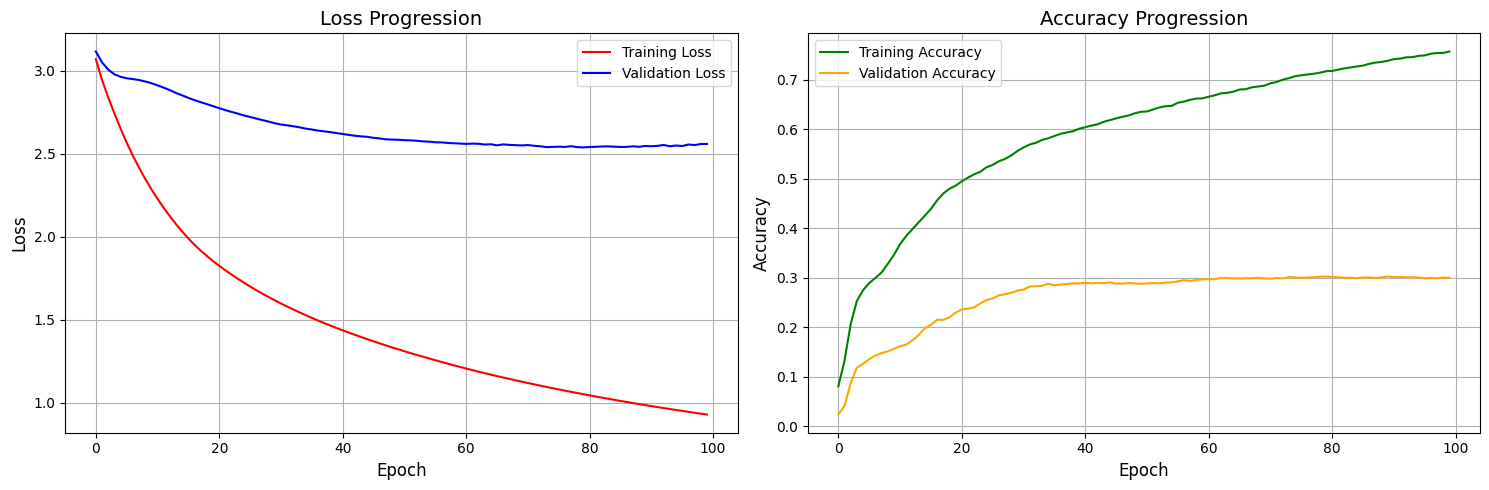

In [51]:
visualize(history, '6s_mfcc_melspectrogram')

In [52]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['mfcc_melspectrogram'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['mfcc_melspectrogram'] = model.evaluate(validation_features, val_y)[-1]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step - accuracy: 0.7636 - loss: 0.9096
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - accuracy: 0.3070 - loss: 2.5359


In [53]:
val_scores['mfcc_melspectrogram'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.36      0.58      0.44       126
           1       0.48      0.45      0.46       205
           2       0.50      0.49      0.49        96
           3       0.21      0.64      0.32       152
           4       0.00      0.00      0.00        33
           5       0.10      0.10      0.10        48
           6       0.00      0.00      0.00        38
           7       0.42      0.62      0.50       107
           8       0.03      0.04      0.03        24
           9       0.18      0.34      0.23        32
          10       0.38      0.38      0.38        69
          11       0.10      0.00      0.01       272
          12       0.30      0.22      0.26       203
          13       0.18      0.12      0.14        76
          14       0.00      0.00      0.00        20
          15       0.29      0.36      0.32       119
          16       0.19      0.14      0.16   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### With Mel Spectrogram

In [55]:
training_features = train_features['melspectrogram']
training_features.shape

(6543, 128)

In [57]:
validation_features = val_features['melspectrogram']
validation_features.shape

(2028, 128)

In [58]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1])

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=0,
)

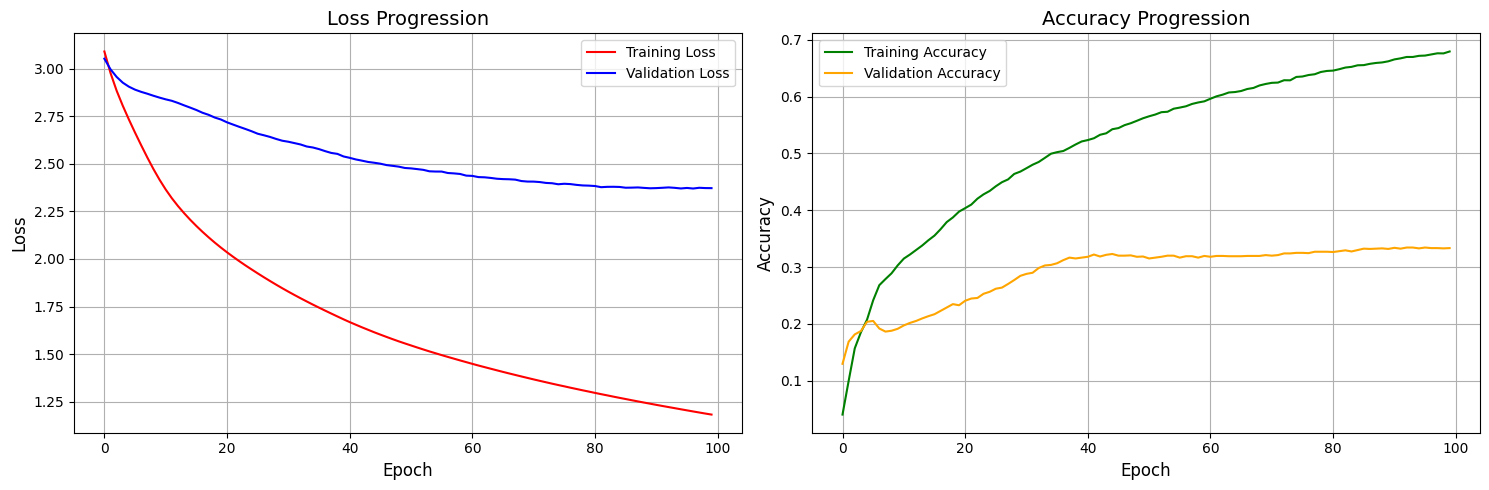

In [59]:
visualize(history, '6s_melspectrogram')

In [60]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram'] = model.evaluate(validation_features, val_y)[-1]

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step - accuracy: 0.6929 - loss: 1.1595
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step - accuracy: 0.3326 - loss: 2.3676


In [61]:
val_scores['melspectrogram'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.48      0.63      0.55       126
           1       0.45      0.44      0.44       205
           2       0.49      0.52      0.51        96
           3       0.23      0.70      0.34       152
           4       0.00      0.00      0.00        33
           5       0.10      0.10      0.10        48
           6       0.00      0.00      0.00        38
           7       0.28      0.26      0.27       107
           8       0.02      0.04      0.03        24
           9       0.71      0.38      0.49        32
          10       0.41      0.57      0.47        69
          11       0.00      0.00      0.00       272
          12       0.17      0.12      0.14       203
          13       0.48      0.16      0.24        76
          14       0.02      0.05      0.03        20
          15       0.26      0.31      0.28       119
          16       0.53      0.85      0.65   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Review all the results

In [62]:
train_results_df = pd.DataFrame(list(train_results.items()), columns=['Features', 'Train_Accuracy']).round(3)
val_results_df = pd.DataFrame(list(val_results.items()), columns=['Features', 'Val_Accuracy']).round(3)

result_df = train_results_df.merge(val_results_df, on='Features')
result_df = result_df.sort_values('Features')
result_df

,Features,Train_Accuracy,Val_Accuracy
0,all_features,0.813,0.350
4,melspectrogram,0.682,0.333
1,melspectrogram_chroma,0.717,0.282
2,melspectrogram_chroma_mfcc,0.769,0.327
3,mfcc_melspectrogram,0.759,0.300


In [63]:
val_scores_df = pd.DataFrame([(key, value['f1'], value['auc']) for key, value in val_scores.items()],
                             columns=['Features', 'F1_Score', 'AUC_Score']).round(3)

val_scores_df = val_scores_df.sort_values('Features')
print(val_scores_df)

                     Features  F1_Score  AUC_Score
0                all_features     0.312      0.798
4              melspectrogram     0.293      0.788
1       melspectrogram_chroma     0.249      0.789
2  melspectrogram_chroma_mfcc     0.291      0.805
3         mfcc_melspectrogram     0.266      0.802
